In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch
import albumentations as A
transform = A.load("/media/newhd/OPTRetina/DMAE/autoalbument-amd/outputs/2021-11-24/10-32-22/policy/latest.json")

In [2]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [3]:
torch.cuda.set_device(1)

In [4]:
df = pd.read_csv('../trainValid.csv')

In [5]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [6]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 384

In [7]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='vit_base_patch32_384_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [8]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [9]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [13]:
learn = Learner(dls,timm.create_model('vit_base_patch32_384',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.251936,0.250850,0.500000,0.500000,1.000000,0.666667,0.584550,03:06


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.181610,0.171546,0.607692,0.597222,0.661538,0.627737,0.660750,03:01
1,0.175743,0.173539,0.579487,0.550654,0.864103,0.672655,0.645855,03:05
2,0.178341,0.198552,0.567949,0.538913,0.941026,0.685341,0.631897,03:04
3,0.167790,0.236519,0.582051,0.572727,0.646154,0.607229,0.587669,03:06
4,0.164236,0.190018,0.601282,0.588764,0.671795,0.627545,0.662705,03:03
5,0.170919,0.183961,0.603846,0.617391,0.546154,0.579592,0.663103,03:06


Better model found at epoch 0 with f1_score value: 0.6277372262773723.


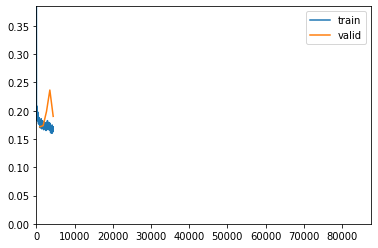

Better model found at epoch 1 with f1_score value: 0.6726546906187625.
Better model found at epoch 2 with f1_score value: 0.6853408029878617.
No improvement since epoch 0: early stopping


In [14]:
learn.fine_tune(100,base_lr=3e-4,wd=0.01)

In [15]:
dfTest = pd.read_csv('../testSample.csv')

In [16]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [17]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [18]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [19]:
learn.dls = dlsTest

In [20]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.7051071663379356.


(#6) [0.17991268634796143,0.5661538243293762,0.5377855887521968,0.9415384615384615,0.6845637583892619,0.7051071663379356]